# treatment_effects

## Testing methods for estimating treatment effects

Current machine learning methods perform very well in the task of estimating conditional outcomes, such as the expectation of a varible given other variables $E[y\ |\ X]$, but have not been widely adopted for estimating counterfactual outcomes, such as estimating what would be the difference in the outcome $y$ of individual I if we used treatment B instead of treatment A. We call this the **treatment effect** $E[y(A)\ -\ y(B)\ |\ X]$, where $y(A)$ is the outcome given treatment A and $y(B)$ is the outcome given treatment B.

In this post, we'll build a treatment effect estimation problem and solve it using Generalized Random Forests, from the recent work of [Athey et. al](https://github.com/grf-labs/grf/blob/master/REFERENCE.md), and a similar but alternative method using extremely randomized trees and embeddings.

## Why is this important?

Treatment effect estimation is one of the central problems in causal inference and has been the focus of many economists for decades. Given that you could accurately perform these estimates, you could do a lot of cool stuff:

1. Determine how would a patient react to different treatments
2. Determine how a different public policy would impact your city
3. Determine how would be the demand for an app if you added/removed one feature
4. and many more!

So, let us start by generating some synthetic data for our experiments!

In [1]:
# plotting inline
%matplotlib inline

# importing necessary modules
import os
import time
import random
import graphviz
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from umap import UMAP
from pynndescent import NNDescent
from sklearn.datasets import make_blobs, make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import tree

# turning off automatic plot showing, and setting style
plt.style.use('bmh')
plt.ioff()

# random seed
np.random.seed(1010)

# setting working directory
os.chdir('C:/Users/Guilherme/Documents/Projetos & Estudos/Side Projects/causal_inference')

## Synthetic Data

Let us generate some synthetic data in order to simulate our problem. First, we generate a dataset of 10000 instances, 20 features (5 informative and 15 non-informative) and 5 clusters using using `make_classification` from `sklearn`:

In [2]:
# number of samples in the data
N_SAMPLES = 10000

# total number of features
N_FEATURES = 20

# number of informative features
N_INFORMATIVE = 5

# number of clusters
N_CLUSTERS = 5

In [3]:
# generating the data
X, cluster = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES, n_informative=N_INFORMATIVE, 
                                 n_redundant=0, n_classes=N_CLUSTERS, n_clusters_per_class=1, shuffle=False,
                                 flip_y=0, class_sep=1.5, random_state=1010)

Then, we generate treatment assignments for each instance. In this case, we assume a logistic function for treatment assignment where the weights are drawn from a normal distribution with mean `ASSIGN_MEAN` and deviation `ASSIGN_STD` and the bias is fixed and equal to `TREAT_BIAS`. The logistic function outputs `treat_probs`, which in turn is used to generate `treat_assignments` via Bernoulli trials.

In this example, `ASSIGN_MEAN` = `ASSIGN_STD` = `TREAT_BIAS` = 0, so all instances have 50% probability of being treated, which is equivalent to a randomized trial. If you want, you can increase the treatment assignment probability for all instances by increasing `TREAT_BIAS`. Also, you can make the treatment assingment correlated to the informative variables by changing `ASSIGN_MEAN` and `ASSIGN_STD`. Doing this will make the treatment effect estimation harder, as we're moving away from a randomized trial (if all instances were treated we cannot know what would happen if they were not treated!).

In [4]:
# mean and std for treatment assignment parameter
ASSIGN_MEAN = 0; ASSIGN_STD = 0

# bias for treatment assignmnent
TREAT_BIAS = 0.0

In [5]:
# generating treatment weights
treat_weights = np.random.normal(ASSIGN_MEAN, ASSIGN_STD, N_FEATURES)

# generating treatment probabilities
treat_probs = 1/(1 + np.exp(-np.dot(X, treat_weights) + TREAT_BIAS))

# generating treatment assingments
treat_assignments = (np.random.uniform(size=N_SAMPLES) > treat_probs).astype(int)

Finally, for each cluster, we draw `prob_params` and `effect_params` from gaussians with parameters `(PROB_MEAN, PROB_STD)` and `(EFFECT_MEAN, EFFECT_STD)`, respectively. `prob_params` acts like a baseline parameter for all instances in a cluster, such that for instance `i`, the probability of a positive outcome is `1/(1 + np.exp(-prob_params[cluster[i]]))`.

Additionally, `effect_params` changes the outcomes for the treated instances such that if instance `i` was treated, its probability of a positive outcome will be `1/(1 + np.exp(-(prob_params[cluster[i]] + effect_params[cluster[i]])))`.

Changing `PROB_MEAN` will bias the outcomes to be more or less positive in average and `EFFECT_MEAN` will bias the treatment effect to be more negative or positive. Increasing `PROB_STD` will make the average outcome more varied per cluster. Increasing `EFFECT_STD` will make the treatment effect more varied per cluster.

In [6]:
# mean and std for cluster probability parameter
PROB_MEAN = 0; PROB_STD = 2.5

# mean and std for treatment effect parameter
EFFECT_MEAN = 0; EFFECT_STD = 2.0

In [7]:
# generating cluster probabilities and treatment effect parameters
prob_params = np.random.normal(PROB_MEAN, PROB_STD, N_CLUSTERS)
effect_params = np.random.normal(EFFECT_MEAN, EFFECT_STD, N_CLUSTERS)

# generating cluster probabilities
cluster_probs = [1/(1 + np.exp(-(prob_params[cluster[i]] + effect_params[cluster[i]]*treat_assignments[i]))) for i in range(N_SAMPLES)]

# generating response
y = (np.random.uniform(size=N_SAMPLES) < cluster_probs).astype(int)

Let us test our new dataset. The follwoing table shows the proportion of treated instances per cluster and the average outcome per cluster. We can see that we have roughly 50% of samples per cluster being treated and clusters of varying average outcomes. 

In [8]:
# let us create a dataframe to get important statistics
datagen_df = pd.DataFrame({'y':y,'treated':treat_assignments,'cluster':cluster})

In [9]:
# checking proportion of positives and treated per cluster
datagen_df.groupby(['cluster']).mean()

,treated,y
cluster,,
0,0.499750,0.012994
1,0.515500,0.981000
2,0.515500,0.164000
3,0.521000,0.315000
4,0.492746,0.599800


Also, we can evaluate the average outcome for treated and not treated instances per cluster. Cluster 0 shows a tiny effect of 2 percentage points whereas Cluster 3 shows a big effect, with a 54 percentage point difference.

In [10]:
# checking proportion of positives per cluster and if under treatment
datagen_df.groupby(['cluster','treated']).mean()

y
cluster treated          
0       0        0.024975
        1        0.001000
1       0        0.960784
        1        1.000000
2       0        0.093911
        1        0.229874
3       0        0.045929
        1        0.562380
4       0        0.711045
        1        0.485279

In [11]:
# let us also show the actual treatment effect
pd.DataFrame({'cluster': range(N_CLUSTERS), 
              'effect': [1/(1 + np.exp(-(prob_params[i] + effect_params[i]))) - \
                         1/(1 + np.exp(-prob_params[i])) for i in range(N_CLUSTERS)]})

,cluster,effect
0,0,-0.024652
1,1,0.036773
2,2,0.110841
3,3,0.541974
4,4,-0.219130


In [12]:
# creating a df with treatment assignments and outcomes
y_df = pd.DataFrame({'id': range(X.shape[0]), 'y':y, 'treats':treat_assignments, 'cluster':cluster})

In [13]:
# creating and saving a df with variables and clusters
X_df = pd.concat([pd.DataFrame(X), pd.DataFrame({'y':y, 'treats':treat_assignments, 'cluster':cluster})], axis=1)
X_df.to_csv('treat_effect_data.csv', index=False)

Cool. Now, our goal is to accurately estimate the treatment effect per sample, and consequently, cluster. Let us start with a well-established method: Generalized Random Forests. 

## Generalized Random Forests

Generalized Random Forests were introduced [in a great paper by Athey et. al](https://arxiv.org/pdf/1610.01271.pdf) and implemented in the neat [grf package](https://github.com/grf-labs/grf/blob/master/REFERENCE.md) for R. We start by reading the data and organizing it in the format required by the `grf` package: `X` as our design matrix, `Y` as the target variable and `W` as our treatment variable. We also get the ground-truth `cluster` for each sample as well.

In [ ]:
# reading our data
df <- read.csv('treat_effect_data.csv')

# extracting relevant variables
X <- df[,1:20]
W <- df[,22]
Y <- df[,23]
cluster <- df[,21]

Then, we use the `causal_forest` function to train a causal forest using `X`, `Y` and `W`. The resulting `tau.forest` can predict $E[y(W = 1)\ -\ y(W = 0)\ |\ X]$, effectively estimating the treatment effect for all samples. 

In [ ]:
# training the causal forest
tau.forest <- causal_forest(X, Y, W)

# Estimate treatment effects for the training data using out-of-bag prediction.
tau.hat.oob <- predict(tau.forest)

# creating a dataframe for evaluation
eval_df <- data.frame(cluster=cluster, effect=tau.hat.oob$predictions, y=Y, treated=W)

We can check how the predictions are distributed and see some promising spikes around the real treatment effects:  

In [ ]:
# showing a histogram of effects
eval_df %>% ggplot(aes(x=effect)) + 
            geom_histogram(bins=60) + 
            ggtitle('Treatment effect estimation using generalized random forests') +
            xlab('Effect') + ylab('Frequency')

We finally compare the estimated treatment effects with the real treatment effects:

In [ ]:
# real_treatment effects
real_effects <- eval_df %>% 
                group_by(cluster, treated) %>% 
                summarise(y_mean=mean(y)) %>% 
                group_by(cluster) %>% 
                summarise(real_effect=y_mean[2] - y_mean[1])

# showing the estimated treatment effect by cluster
estimated_effects <- eval_df %>%
                     group_by(cluster) %>%
                     summarise(estimated_effect=mean(effect))

# joining
merge(real_effects, estimated_effects)

The estimates seem ok! We can see that the estimation error increases with the effect size. This may be due to averaging neighborhoods. As the *grf* method uses co-ocurrence on the leaves of a random forest to build pairwise similarities, each sample has its own neighborhood. This neighborhood may include samples from other clusters, which mess up the estimation a little bit.

Nonetheless, the *grf* method is proven to be a consistent estimator for the treatment effect and will converge to the real efffect given more samples. Now, can we approximate these results with a different and simpler method, not focusing on theoretical guarantees? Let us try that with extremely randomized trees and embeddings.

## Model: Neighborhoods, Extremely Randomized Trees, and Embeddings

In this method, we first perform a supervised embedding of the data and then try to estimate treatment effects for each sample by using its neighborhood in the embedding:

1. Fit an Extremely Randomized Tree Forest to the data, excluding the treatment variable
2. Calculate a pairwise similarity metric for all samples by counting in how many leaf nodes of the forest two samples co-occurred
3. Determine the 100 nearest neighbors for each sample (we use NN-Descent for efficiency)
4. In each 100-nearest neighbor group, calculate y(1) - y(0), weighted by the similarities

First, we validate our model, to check if the chosen hyperaparameters are OK:

In [14]:
# CV method
skf = StratifiedKFold(n_splits=5, shuffle=True)

# model 
et = ExtraTreesClassifier(n_estimators=200, min_samples_leaf=5, bootstrap=True, n_jobs=-1)
#et = RandomForestClassifier(n_estimators=200, min_samples_leaf=100, bootstrap=True, n_jobs=-1)

In [15]:
# generating validation predictions
auc = cross_val_score(et, X, y, cv=skf, scoring='roc_auc')

# calculating AUC
print(auc, np.mean(auc))

[0.83414936 0.83724076 0.82010777 0.83661753 0.82249147] 0.8301213792506686


Cool, average validation AUC of 0.83 is enough. Let us continue by fitting the model to the whole dataset and obtaining its leaf assignments.

In [16]:
# let us train our model with the full data
et.fit(X, y)

# and get the leaves that each sample was assigned to
leaves = et.apply(X)
leaves

array([[1068, 1139, 1205, ..., 1117,  426,  468],
       [ 590, 1049,   79, ..., 1085,  710,  344],
       [1015, 1347,    8, ..., 1128,   31, 1184],
       ...,
       [ 480,   97,  564, ...,  900,  118,  231],
       [ 731,  384,  589, ...,  944,  393,  792],
       [ 284,  494,  330, ...,  904,  104,  225]], dtype=int64)

Now, we check the embedding to see what the model has learned. It is very easy to do that with `UMAP` and `matplotlib`:

In [ ]:
# let us check the embedding with response and treatments
embed = UMAP(metric='hamming').fit_transform(leaves)

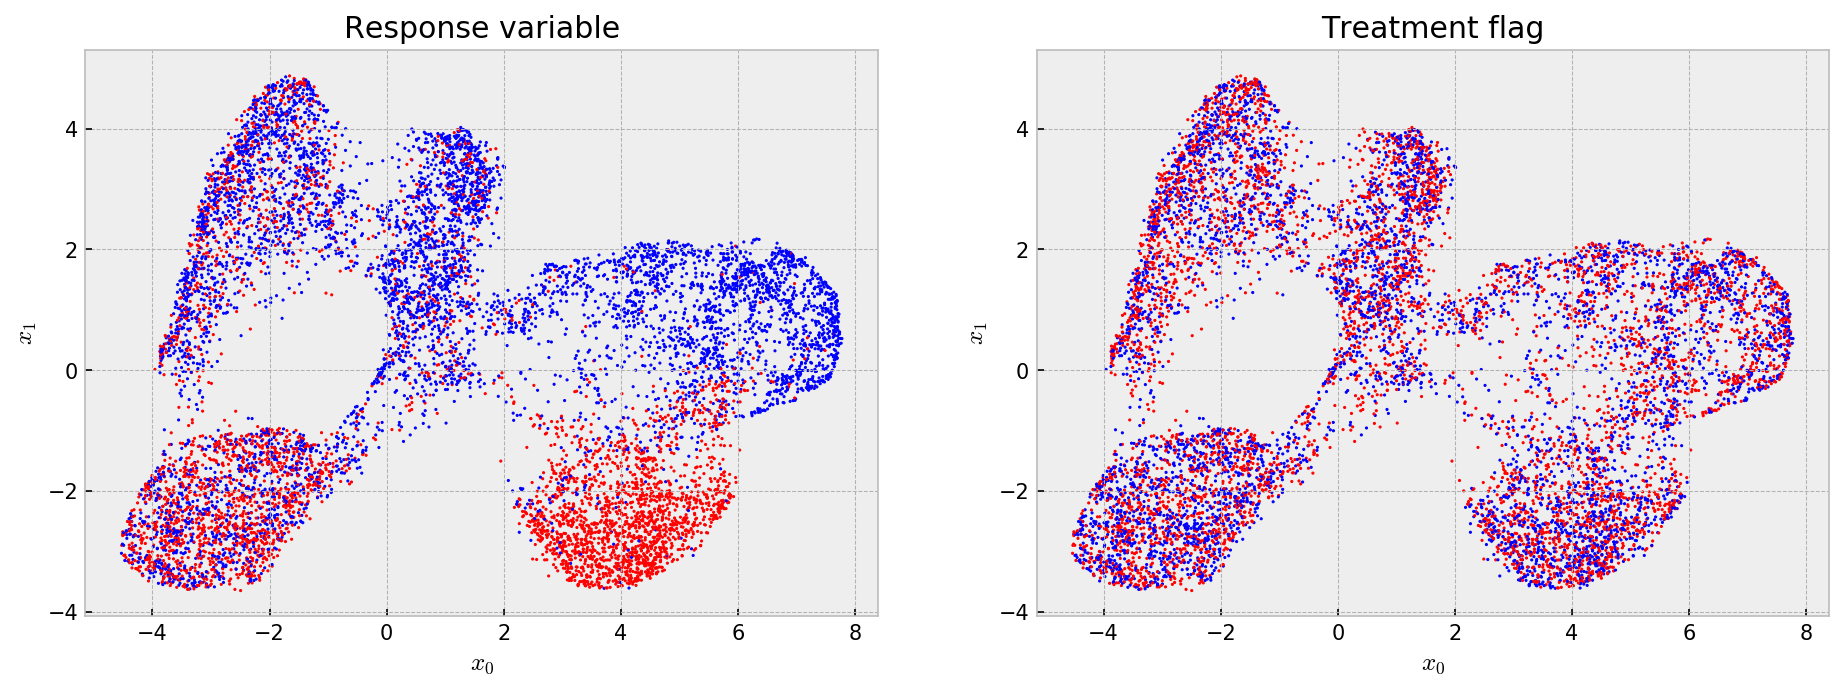

In [17]:
# opening figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=150)

# first figure shows the response variable
axes[0].scatter(embed[:,0], embed[:,1], s=1, c=y, cmap='bwr')
axes[0].set_title('Response variable')
axes[0].set_xlabel('$x_0$'); axes[0].set_ylabel('$x_1$')

# second shows the treatment variable
im = axes[1].scatter(embed[:,0], embed[:,1], s=1, c=treat_assignments, cmap='bwr')
axes[1].set_title('Treatment flag')
axes[1].set_xlabel('$x_0$'); axes[1].set_ylabel('$x_1$')

# showing
plt.show()

Cool! The embedding shows that the model learned (more or less) five clusters with different average outcomes and that the treatment assignments are uniform across the embedding, such that at every point we have a randomized trial for estimating treatment effects. Now, we build an index for nearest neighbor search and get the 100-NN for all our samples.

In [18]:
# let us use soft-clustering to estimate treatment effects in the neighborhood
index = NNDescent(leaves, metric='hamming')

In [19]:
# querying 100 nearest neighbors
nearest_neighs = index.query(leaves, k=100)

We do some `pandas` magic to efficiently calculate treament effects for each sample. First, we structure the 100 nearest neighors indexes and similarities for each sample:

In [20]:
# creating df with nearest neighbors
nearest_neighs_df = pd.DataFrame(nearest_neighs[0])

# creating df with nearest neighbor weights
nearest_neighs_w_df = pd.DataFrame(1 - nearest_neighs[1])
nearest_neighs_w_df[0] = nearest_neighs_df[0] # adding index

In [21]:
# processing the neighbors df
nearest_neighs_df = (nearest_neighs_df
                     .melt(id_vars=0)
                     .rename(columns={0:'ref','value':'id'})
                     .reset_index(drop=True))

In [22]:
# processing the neighbor weights df
nearest_neighs_w_df = (nearest_neighs_w_df
                       .melt(id_vars=0)
                       .rename(columns={0:'ref','value':'weight'})
                       .reset_index(drop=True))

In [23]:
# joining the datasets and adding weighted y variable
nearest_neighs_df = (nearest_neighs_df
                     .merge(nearest_neighs_w_df)
                     .drop('variable', axis=1)
                     .merge(y_df, on='id', how='left')
                     .assign(y_weighted = lambda x: x.y*(x.weight)))

Then, for each sample, we calculate response variable averages for treated and not treated neighbors, and calculate the weighted and non-weighted treatment effects.

In [44]:
# processing to get the effects
treat_effect_df = nearest_neighs_df.assign(dummy=1).groupby(['ref','treats']).sum()
treat_effect_df['y_weighted'] = treat_effect_df['y_weighted']/treat_effect_df['weight']
treat_effect_df['y'] = treat_effect_df['y']/treat_effect_df['dummy']
treat_effect_df = treat_effect_df.pivot_table(values=['y', 'y_weighted','weight'], columns='treats', index='ref')

In [45]:
# calculating treatment effects
treat_effect_df.loc[:,'effect'] = treat_effect_df['y'][1] - treat_effect_df['y'][0]
treat_effect_df.loc[:,'effect_weighted'] = treat_effect_df['y_weighted'][1] - treat_effect_df['y_weighted'][0]

We now calculate the real treatment effects and evaluate our model. 

In [46]:
# calculating real effects
treatment = np.array([1/(1 + np.exp(-(prob_params[cluster[i]] + effect_params[cluster[i]]))) for i in range(N_SAMPLES)])
no_treatment = np.array([1/(1 + np.exp(-(prob_params[cluster[i]]))) for i in range(N_SAMPLES)])
real_effect = treatment - no_treatment

In [47]:
# comparting estimated and real effects
eval_df = pd.DataFrame({'estimated_pure':treat_effect_df['effect'],
                        'estimated_weighted':treat_effect_df['effect_weighted'],
                        'real':real_effect, 'cluster':cluster})

The first thing to note is the distribution of estimated effect, which looks a little bit different from the one obtained from *grf*:

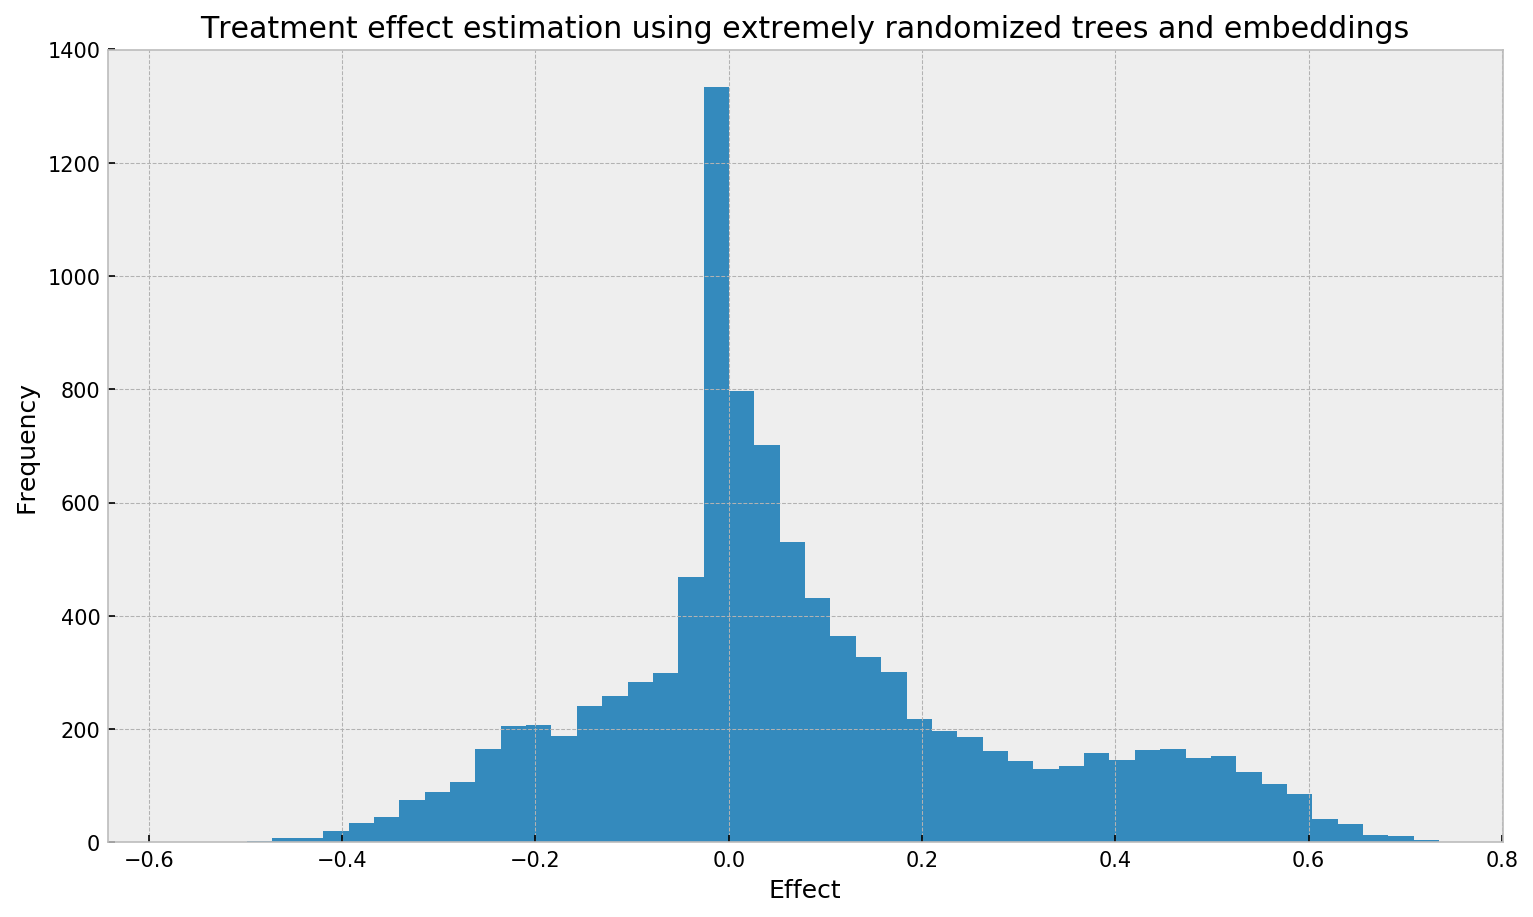

In [48]:
# opening figure
plt.figure(figsize=(12,7), dpi=150)

# plotting histogram
plt.hist(eval_df['estimated_weighted'], bins=50);

# titles
plt.title('Treatment effect estimation using extremely randomized trees and embeddings')
plt.ylabel('Frequency'); plt.xlabel('Effect');

We cannot see clear spikes here, as opposed to the *grf* plot. The smoother plot may be due to many things: larger bias from the neighborhood size, the method used, the smoother similairities from extremely randomized trees, the lack of honesty in fitting the trees, or the non-explicit objective used for fitting the trees (*grf* uses a special decision tree method that tries to directly optimize the treatment effect objective).

Let us compare the estimated effects to the real ones, by cluster:

In [49]:
# comparing estimated and real treatment effect per cluster
eval_df.groupby('cluster').mean()

,estimated_pure,estimated_weighted,real
cluster,,,
0,0.013948,0.012510,-0.024652
1,0.023163,0.022614,0.036773
2,0.134016,0.132716,0.110841
3,0.389115,0.396578,0.541974
4,-0.159797,-0.164047,-0.219130


Cool! The weighted treatment effect estimation fared a little bit better than the non-weighted version. We also underestimate stronger effects (Clusters 3 and 4), probably due to bias from the relatively large neighborhood size. The estimation error seems a little bit better than with *grf*, but we cannot really compare the methods as *grf* comes with theoretical guarantees. Anyway, this is evidence in favour to our simple method, showing that it can work. 

Finally, we check the individual estimates using the UMAP embedding:

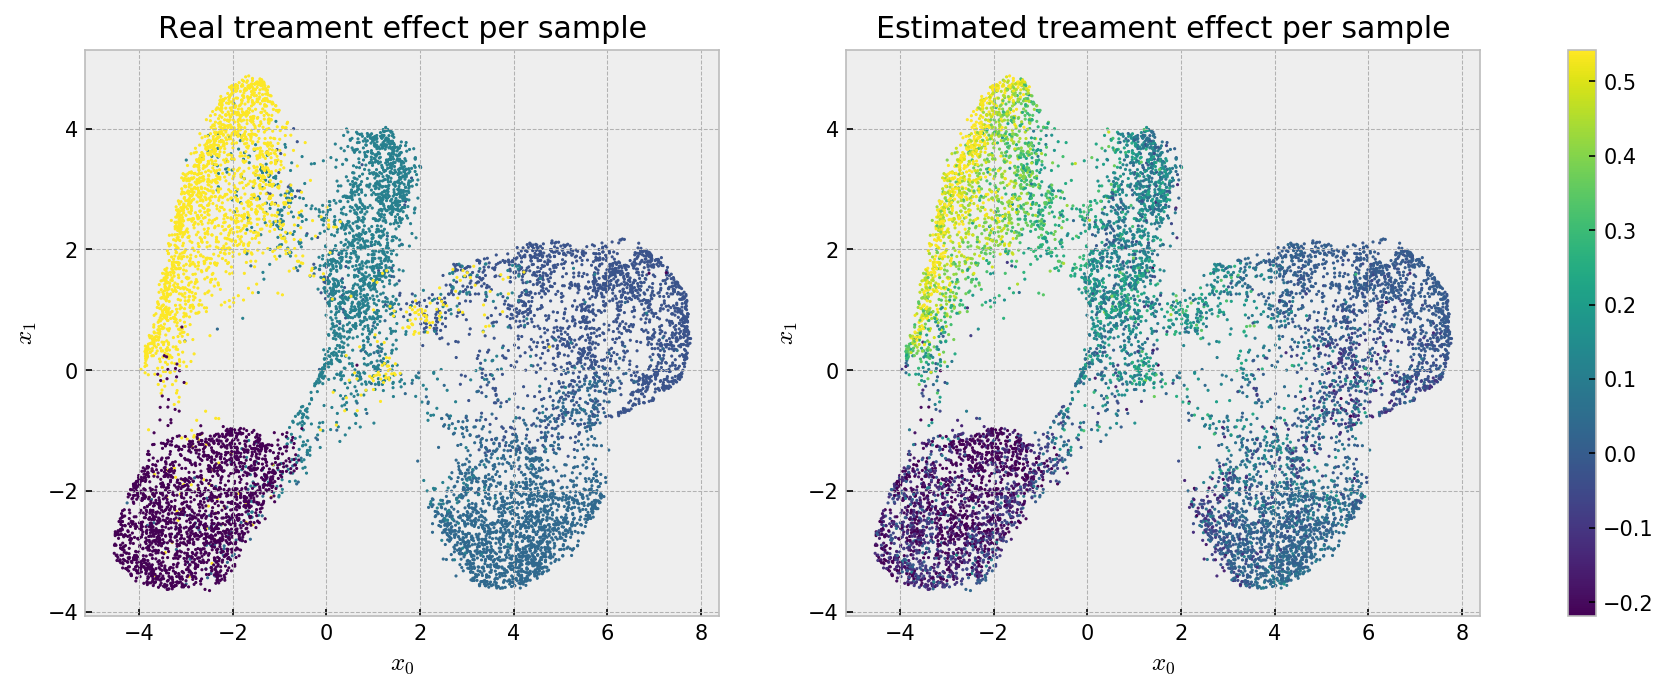

In [50]:
# opening figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=150)

# first figure is real treatment effect
axes[0].scatter(embed[:,0], embed[:,1], s=1, c=eval_df['real'], cmap='viridis', vmin=eval_df['real'].min(), vmax=eval_df['real'].max())
axes[0].set_title('Real treament effect per sample')
axes[0].set_xlabel('$x_0$'); axes[0].set_ylabel('$x_1$')

# second figure is estimated treatment effect
im = axes[1].scatter(embed[:,0], embed[:,1], s=1, c=eval_df['estimated_weighted'], cmap='viridis', vmin=eval_df['real'].min(), vmax=eval_df['real'].max())
axes[1].set_title('Estimated treament effect per sample')
axes[1].set_xlabel('$x_0$'); axes[1].set_ylabel('$x_1$')

# showing colorbar
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax)
plt.show()

Here we can see that the bias that makes our estimates less accurate at the cluster level may be beneficial, as we see a well behaved effect estimation, with relatively low variance across instances. We can observe an even better pattern if we check the same plot for `grf` estimates:

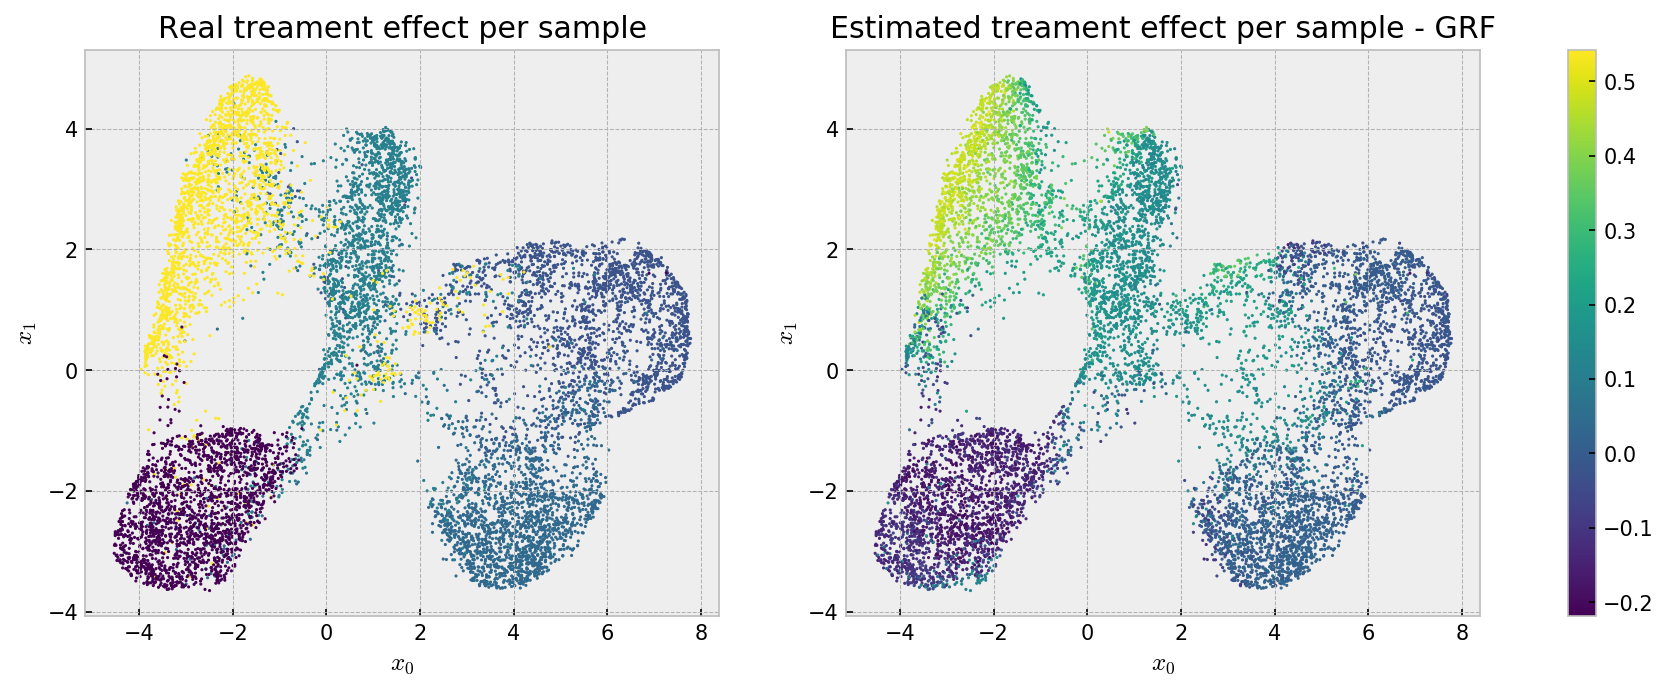

In [56]:
# opening figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=150)

# first figure is real treatment effect
axes[0].scatter(embed[:,0], embed[:,1], s=1, c=eval_df['real'], cmap='viridis', vmin=eval_df['real'].min(), vmax=eval_df['real'].max())
axes[0].set_title('Real treament effect per sample')
axes[0].set_xlabel('$x_0$'); axes[0].set_ylabel('$x_1$')

# second figure is estimated treatment effect
im = axes[1].scatter(embed[:,0], embed[:,1], s=1, c=grf['effect'], cmap='viridis', vmin=eval_df['real'].min(), vmax=eval_df['real'].max())
axes[1].set_title('Estimated treament effect per sample - GRF')
axes[1].set_xlabel('$x_0$'); axes[1].set_ylabel('$x_1$')

# showing colorbar
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax)
plt.show()

Smooth! Both methods solved the problem, with smoother estimates from `grf`.  

## Conclusion

In this post, we built a causal effect problem and tested two methods for causal effect estimation: the well-established Generalized Random Forests, and a alternative method with extremely randomized trees and embeddings. As expected, *grf* solves the problem and makes stable and accurate treatment effect estimates. Also, our alternative method performed surprisingly well, effectively capturing treatment effects, even if with less stable estimates.

I invite you to run the code with different data generation and model parameters, to check what drives accurate treatment effect estimation. There are many things to test, such as checking the impact of bias in treatment assignment, different models to obtain neighborhoods (such as gradient boosting), using boostrap samples of neighborhoods to try to devise confidence intervals for treatment effects... The possibilities are endless! 

I hope you liked the post! As usual, full code can be found at [my Github]. Thanks!!! 